In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from torch.distributions import Normal

# Loading Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:

# Save the datasets
torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')

# Build NN (bias=0)

In [4]:
class CustomizableNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, num_layers, use_bias):
        super(CustomizableNN, self).__init__()

        # Validate input
        assert num_layers == len(hidden_sizes), "Number of hidden layers should match the length of hidden_sizes."

        # Input layer
        layers = [nn.Linear(input_size, hidden_sizes[0], bias=use_bias[0]), nn.Sigmoid()]

        # Hidden layers
        for i in range(1, num_layers):
            layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i], bias=use_bias[i]), nn.Sigmoid()]

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size, bias=use_bias[-1]))

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage:
input_size = 28 * 28
output_size = 10
# hidden_sizes = [512, 256, 128, 64]
hidden_sizes = [16, 16, 16, 16]
num_layers = len(hidden_sizes)
use_bias =[0, 0, 0, 0, 0]


In [5]:
def reshape(original_list, rows=4, columns=16, add_size=10):
    reshaped_list = [original_list[i:i + columns] for i in range(0, rows * columns, columns)]
    add = original_list[-add_size:]
    reshaped_list.append(add)
    return reshaped_list



# Loss cross entropy

In [6]:
# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# # Training the model
# num_epochs = 4  # Reduce the number of epochs for demonstration purposes
# for epoch in range(num_epochs):
#     for inputs, labels in train_loader:
#         # Forward pass
#         outputs = model(inputs.view(-1, 28 * 28))
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Loss MSE

In [7]:
# Define Mean Squared Error (MSE) as the loss function
def loss_back(model, num_epochs, criterion = nn.MSELoss(), lr=0.001):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Training the model
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            # Forward pass
            
            outputs = model(inputs.view(-1, 28 * 28))
            # Convert labels to one-hot encoding for MSE
            labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()

            # Compute MSE loss
            loss = criterion(outputs, labels_one_hot)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [8]:
# Create a customizable neural network
model = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias)
loss_back(model, num_epochs=12, criterion = nn.MSELoss(), lr=0.001)

Epoch [1/12], Loss: 0.0755
Epoch [2/12], Loss: 0.0543
Epoch [3/12], Loss: 0.0444
Epoch [4/12], Loss: 0.0330
Epoch [5/12], Loss: 0.0332
Epoch [6/12], Loss: 0.0275
Epoch [7/12], Loss: 0.0158
Epoch [8/12], Loss: 0.0113
Epoch [9/12], Loss: 0.0171
Epoch [10/12], Loss: 0.0216
Epoch [11/12], Loss: 0.0179
Epoch [12/12], Loss: 0.0054


# TEST

In [9]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.view(-1, 28 * 28))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 92.16%


# Estimated parameters

In [10]:
# Print the result weights and biases of each layer
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'weight' in name:
        print(f'Weights: {param.data.size()}')
    elif 'bias' in name:
        print(f'Biases: {param.data.size()}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Weights: torch.Size([16, 784])
Layer: model.2.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.4.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.6.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.8.weight, Size: torch.Size([10, 16])
Weights: torch.Size([10, 16])


# Gradient loss of parameter

In [11]:
# Print the derivatives of the loss with respect to each parameter
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    #print(f'Gradient: {param.grad}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Layer: model.2.weight, Size: torch.Size([16, 16])
Layer: model.4.weight, Size: torch.Size([16, 16])
Layer: model.6.weight, Size: torch.Size([16, 16])
Layer: model.8.weight, Size: torch.Size([10, 16])


# Fisher Information

In [12]:
def fisher_diagonal(model,i):
    all_gradients_weight = [param.grad for name, param in model.named_parameters() if "weight" in name ]
    all_gradients_bias = [param.grad for name, param in model.named_parameters() if "bias" in name ]
    grad_vector_weight_hidden = torch.cat([g.contiguous().view(-1) for g in all_gradients_weight[1:-1]])
    grad_vector_weight_output = torch.cat([g.contiguous().view(-1) for g in all_gradients_weight[-1][i]])
    grad_vector_weight = torch.cat([grad_vector_weight_hidden, grad_vector_weight_output],0)
    if len(all_gradients_bias) > 0:
        grad_vector_bias_hidden = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias[:-1]])
        grad_vector_bias_output = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias[-1]])
        grad_vector_bias = torch.cat([grad_vector_bias_hidden, grad_vector_bias_output],0)
        grad_vector = torch.cat([grad_vector_weight,grad_vector_bias],0)
    else:
        grad_vector = grad_vector_weight
    grad_vector = grad_vector.view(-1, 1)
#         for param, gradient in zip(model.parameters(), all_gradients):
#             print(f"Gradient of loss w.r.t. {param[i]}:")
#             print(gradient)
#             print()
#         print('='*20)
#         print(grad_vector)
    G=torch.transpose(grad_vector,0,1)
    F=torch.matmul(grad_vector,G)
    return F,G,grad_vector

# Process the output and labels as probability.

In [13]:
def prob(outputs,labels):
    # re-probability outputs
    mini, _ = torch.min(outputs.data, 1)

    re_outputs = outputs-mini.view(-1, 1)
    re_outputs_p = re_outputs/torch.sum(re_outputs,1).view(-1, 1)
    
    # re-probability labels
    _, predicted = torch.max(outputs.data, 1)
    num_elements = labels.numel()
    identity_matrix = torch.eye(10)
    re_labels_p = nn.functional.one_hot(labels, num_classes=10).float()
#     re_labels_p = identity_matrix[labels] # set probability of labels
    return re_outputs_p, re_labels_p

# Confidence interval and Predictive interval

In [14]:
def confi_pred_interval(inputs, labels, model, a=0.05):
    """
    Function:
    - Calculate the confidence interval and predictive interval of results
    Input:
    - inout: The input of data
    - label: The label of handwriting input
    - model: The trained neural network
    - a: significant level
    Returns:
    - c: the size of confidence interval
    - c_p: the list of confidence interval for each kinds label {0,1,...,9}
    - mu: the estimate output
    - y_p: the list of predictive interval for each kinds label {0,1,...,9}
    """
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs.view(-1, 28 * 28))
    re_outputs_p, re_labels_p = prob(outputs,labels)
   
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
    #loss = (torch.sum((re_outputs_p-re_labels_p)**2,1)/2)
    loss = (torch.mean((re_outputs_p-re_labels_p),dim=0)**2)
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = (torch.sum((re_outputs_p-y_p)**2,1)/2)

    for i in range(10):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H=torch.pinverse(F) #use the pseudo-inverse 
        w=torch.mm(G,H)
        w=torch.mm(w,grad_vector)
        print(w)
        
        
        # CI
#         sigma_epsilon_squared = loss[i]/len(labels)
        sigma_epsilon_squared = 1/4*loss[i]
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
        print(f"interva size:{ci}")
        print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [15]:
for inputs, labels in test_loader:
    
    c, c_p, mu, y_p= confi_pred_interval(inputs, labels, model, a=0.05)
    break

number:0
tensor([[1.2452]])
interva size:tensor([[0.0031]], grad_fn=<MulBackward0>)
p interva size:0.14025366306304932
number:1
tensor([[1.3291]])
interva size:tensor([[0.0153]], grad_fn=<MulBackward0>)
p interva size:0.12582425773143768
number:2
tensor([[1.1548]])
interva size:tensor([[0.0042]], grad_fn=<MulBackward0>)
p interva size:0.1040041521191597
number:3
tensor([[0.3734]])
interva size:tensor([[0.0074]], grad_fn=<MulBackward0>)
p interva size:0.1381698101758957
number:4
tensor([[1.0751]])
interva size:tensor([[0.0056]], grad_fn=<MulBackward0>)
p interva size:0.13243886828422546
number:5
tensor([[2.1461]])
interva size:tensor([[0.0233]], grad_fn=<MulBackward0>)
p interva size:0.11980225890874863
number:6
tensor([[0.9738]])
interva size:tensor([[0.0060]], grad_fn=<MulBackward0>)
p interva size:0.1149463802576065
number:7
tensor([[0.1808]])
interva size:tensor([[0.0030]], grad_fn=<MulBackward0>)
p interva size:0.13944020867347717
number:8
tensor([[1.7689]])
interva size:tensor([[0

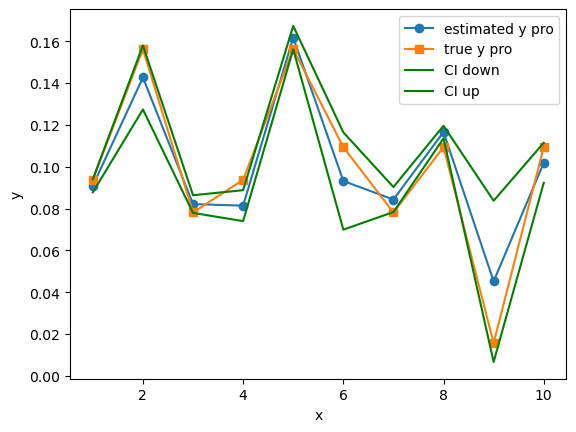

In [16]:
x_np = range(1, 11)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated y pro')
plt.plot(x_np, y_np, 's-', label='true y pro')
plt.plot(x_np, c_np[0,:,0], '-', label='CI down', color='green')
plt.plot(x_np, c_np[0,:,1], '-', label='CI up',color='green')
# plt.plot(x_np, c_p_np[0,:,0], '-', label='CI_p down', color='red')
# plt.plot(x_np, c_p_np[0,:,1], '-', label='CI_p up', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()


# Building NN (bias=unknown)

In [38]:
model_adj = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias = [True,True,True,True,True] )

In [39]:
loss_back(model_adj, num_epochs=12, criterion = nn.MSELoss(), lr=0.001)

Epoch [1/12], Loss: 0.0806
Epoch [2/12], Loss: 0.0600
Epoch [3/12], Loss: 0.0382
Epoch [4/12], Loss: 0.0381
Epoch [5/12], Loss: 0.0355
Epoch [6/12], Loss: 0.0209
Epoch [7/12], Loss: 0.0182
Epoch [8/12], Loss: 0.0223
Epoch [9/12], Loss: 0.0085
Epoch [10/12], Loss: 0.0086
Epoch [11/12], Loss: 0.0134
Epoch [12/12], Loss: 0.0090


In [40]:
# Print the result weights and biases of each layer
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'weight' in name:
        print(f'Weights: {param.data.size()}')
    elif 'bias' in name:
        print(f'Biases: {param.data.size()}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Weights: torch.Size([16, 784])
Layer: model.0.bias, Size: torch.Size([16])
Biases: torch.Size([16])
Layer: model.2.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.2.bias, Size: torch.Size([16])
Biases: torch.Size([16])
Layer: model.4.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.4.bias, Size: torch.Size([16])
Biases: torch.Size([16])
Layer: model.6.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.6.bias, Size: torch.Size([16])
Biases: torch.Size([16])
Layer: model.8.weight, Size: torch.Size([10, 16])
Weights: torch.Size([10, 16])
Layer: model.8.bias, Size: torch.Size([10])
Biases: torch.Size([10])


In [41]:
# Print the derivatives of the loss with respect to each parameter
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
#     print(f'Gradient: {param.grad}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Layer: model.0.bias, Size: torch.Size([16])
Layer: model.2.weight, Size: torch.Size([16, 16])
Layer: model.2.bias, Size: torch.Size([16])
Layer: model.4.weight, Size: torch.Size([16, 16])
Layer: model.4.bias, Size: torch.Size([16])
Layer: model.6.weight, Size: torch.Size([16, 16])
Layer: model.6.bias, Size: torch.Size([16])
Layer: model.8.weight, Size: torch.Size([10, 16])
Layer: model.8.bias, Size: torch.Size([10])


# Numerical way to calculate $\frac{\partial s}{\partial \alpha}$

In [42]:
def numerical_derivative(model,NN, bias, j,epsilon):
    """
    Function:
    -Numerically approximate the derivative of a function f at point x using finite differences.
    Input:
    - model:the Neural network model
    - bias: The bias list for 
    - i: The index of target output
    - j: The index of target bias to derivative
    Returns:
    - derivative for parameter y[i]
    """
    derivative = torch.tensor([])
    bias_plus_epsilon = bias
    bias_minus_epsilon = bias
    bias_plus_epsilon[j] = bias[j] + epsilon
    bias_minus_epsilon[j] = bias[j] - epsilon
    bias_plus = reshape(bias_plus_epsilon)
    bias_minus = reshape(bias_minus_epsilon)
    model_up = NN(input_size, output_size, hidden_sizes, num_layers, bias_plus)
    model_down = NN(input_size, output_size, hidden_sizes, num_layers, bias_minus)
    print("backforward up")
    loss_back(model_up, num_epochs=1, lr=0.001)
    print("backforward down")
    loss_back(model_down, num_epochs=1, lr=0.001)
    
    for i in range(10):
        all_gradients_bias_up = [param.grad for name, param in model_up.named_parameters() if "weight" in name ]
        grad_vector_bias_hidden_up = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_up[1:-1]])
        grad_vector_bias_output_up = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_up[-1][i]])
        grad_vector_bias_up = torch.cat([grad_vector_bias_hidden_up, grad_vector_bias_output_up],0)
        grad_vector_bias_up = grad_vector_bias_up.view(-1, 1)
        
        all_gradients_bias_down = [param.grad for name, param in model_down.named_parameters() if "weight" in name ]
        grad_vector_bias_hidden_down = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_down[1:-1]])
        grad_vector_bias_output_down = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_down[-1][i]])
        grad_vector_bias_down = torch.cat([grad_vector_bias_hidden_down, grad_vector_bias_output_down],0)
        grad_vector_bias_down = grad_vector_bias_down.view(-1, 1)
        
        each_derivative = (grad_vector_bias_up-grad_vector_bias_down)/ 2 * epsilon
        derivative = torch.cat([derivative, each_derivative.unsqueeze(0)], 0)
    
    return derivative
    

In [43]:
def derivative_whole(use_bias, epsilon=1e-6):
    dS_da_whole = torch.tensor([])
    for j in range(len(use_bias)):
        detrivate = numerical_derivative(model,CustomizableNN, deepcopy(use_bias), j,epsilon)
        dS_da_whole = torch.cat([dS_da_whole, detrivate], -1)
    return dS_da_whole

In [44]:
# dS_da_whole=derivative_whole(use_bias=[0 for _ in range(4*16+1*10)])

In [45]:
# torch.save(dS_da_whole, 'dS_da_whole_tensor_epoch1.pt')
loaded_tensor_epoch1 = torch.load('dS_da_whole_tensor_epoch1.pt')
dS_da_whole_epoch1 = loaded_tensor_epoch1

In [46]:
# torch.save(dS_da_whole, 'dS_da_whole_tensor.pt')
loaded_tensor = torch.load('dS_da_whole_tensor.pt')
dS_da_whole = loaded_tensor

# Estimate Var($\alpha$):
estimate bias for each batch, and use Bayesian way to estimate variance of each bias parameter

In [47]:
# Store estimated bias terms for each batch
model_va = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias = [True,True,True,True,True] )
estimated_bias_per_batch = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model_va.parameters(), lr=0.001)  
# Training loop
i=0
for inputs, labels in train_loader:
    i+=1
    # Training the model
    # Zero the gradients
    optimizer.zero_grad()
    for epoch in range(5):
            outputs = model_va(inputs.view(-1, 28 * 28))
            labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()
            loss = criterion(outputs, labels_one_hot)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    estimated_bias_per_layer = [param.detach().numpy() for name, param in model_va.named_parameters() if 'bias' in name]
    estimated_bias_per_layer =np.concatenate(estimated_bias_per_layer).tolist()
    estimated_bias_per_batch.append(estimated_bias_per_layer)



In [48]:
data_list = [per_batch[0] for per_batch in estimated_bias_per_batch]
data = torch.tensor(data_list, dtype=torch.float32)

In [49]:
def variance(data):
    # Define the Bayesian linear regression model
    class BayesianLinearRegression(nn.Module):
        def __init__(self):
            super(BayesianLinearRegression, self).__init__()
            self.mean_weight = nn.Parameter(torch.randn(1))
            self.log_variance_weight = nn.Parameter(torch.randn(1))

        def forward(self, x):
            mean = x * self.mean_weight
            variance = torch.exp(self.log_variance_weight)
            return Normal(mean, variance.sqrt())

    # Instantiate the model and set up optimization
    model_B = BayesianLinearRegression()
    optimizer = optim.Adam(model_B.parameters(), lr=0.01)

    # Training loop for Bayesian inference
    num_epochs = 1000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        likelihood = model_B(data)
        loss = -likelihood.log_prob(data).sum()  # Negative log likelihood as loss
        loss.backward()
        optimizer.step()

    # Get the estimated variance from the model
    estimated_variance = torch.exp(model_B.log_variance_weight).item()
    return estimated_variance

In [50]:
V = []
for i in range(len(estimated_bias_per_batch[1])):
    data_list = [per_batch[i] for per_batch in estimated_bias_per_batch]
    data = torch.tensor(data_list, dtype=torch.float32)
    var = variance(data)
    V.append(var)
V = torch.tensor(V)   

In [51]:
# import numpy as np
# datasets=[]
# for i in range(len(estimated_bias_per_batch[1])):
#     data_list = [per_batch[i] for per_batch in estimated_bias_per_batch]
#     datasets.append(data_list)
# covariance_matrix = np.cov(datasets)

# print("Covariance Matrix:")
# print(covariance_matrix)
# V=covariance_matrix
# def Adjust(model_adj,num_layers,dS_da_whole_epoch1,V):
#     Adj = torch.tensor([])
#     for i in range(10):
#         F, G, grad_vector = fisher_diagonal(model_adj,i)
#         F_in= torch.pinverse(F)
#         r = len(F)
#         l = sum(hidden_sizes)+10
#         n = len(train_loader)
# #         Va = torch.diag(V, diagonal=0)
# #         Va = torch.diag(torch.tensor([1] * l), diagonal=0)

#         Va = torch.tensor(V, dtype=torch.float32)
#         Vo = F_in[0:r-l,0:r-l]
#         print(Vo)
#         dS_da = dS_da_whole[i,:,:]
#         D = torch.mm(Vo,dS_da)
#         D_t = torch.transpose(D,0,1)
#         if D.dtype != Va.dtype:
#             Va = Va.to(D.dtype)
#         A = torch.mm(D,Va)
#         A = torch.mm(A,D_t)
#         Adj = torch.cat([Adj, A.unsqueeze(0)], 0)
#     return Adj

# Adjustment term

In [52]:
def Adjust(model_adj,num_layers,dS_da_whole_epoch1,V):
    Adj = torch.tensor([])
    for i in range(10):
        F, G, grad_vector = fisher_diagonal(model_adj,i)
        F_in= torch.pinverse(F)
        r = len(F)
        l = 74
        n = len(train_loader)
        Va = torch.diag(V, diagonal=0)
#         Va = torch.diag(torch.tensor([1] * l), diagonal=0)
        Vo = F_in[0:r-l,0:r-l]
        dS_da = dS_da_whole[i,:,:]
        D = torch.mm(Vo,dS_da)
        D_t = torch.transpose(D,0,1)
        if D.dtype != Va.dtype:
            Va = Va.to(D.dtype)
        A = torch.mm(D,Va)
        A = torch.mm(A,D_t)
        Adj = torch.cat([Adj, A.unsqueeze(0)], 0)
    return Adj

In [53]:
Adj= Adjust(model_adj,num_layers,dS_da_whole,V)

In [54]:
def adj_confi_pred_interval(inputs, labels, model,Adj, a=0.05):
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs.view(-1, 28 * 28))
    re_outputs_p, re_labels_p = prob(outputs,labels)
    
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
#     loss = (torch.sum((re_outputs_p-re_labels_p)**2,1)/2)
    loss = (torch.mean((re_outputs_p-re_labels_p),dim=0)**2)
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = (torch.sum((re_outputs_p-y_p)**2,1)/2)
    
    for i in range(10):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H = torch.pinverse(F) #use the pseudo-inverse 
        H = H + Adj[i]
        w = torch.mm(G,H)
        w = torch.mm(w,grad_vector)

        # CI
#         sigma_epsilon_squared = loss[i]/len(labels)
        sigma_epsilon_squared = 1/4*loss[i]
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        print(ci)
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
#         print(f"interva size:{ci}")
#         print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [55]:
import torch

# Initialize empty lists to accumulate data
X_list = []
y_list = []
i=0
# Iterate over the batches in the test_loader
for inputs, labels in test_loader:
    i+=1
    # Append the batch data to the lists
    X_list.append(inputs)
    y_list.append(labels)
    if i==100:
        break
# Concatenate the lists to create a single dataset pair
X = torch.cat(X_list, dim=0)
y = torch.cat(y_list, dim=0)
print(f"sample size{X.size()}")
adj_c, adj_c_p, mu, y_p= adj_confi_pred_interval(X, y, model, Adj, a=0.025)
c, c_p, mu, y_p= confi_pred_interval(X, y, model, a=0.025)


sample sizetorch.Size([6400, 1, 28, 28])
number:0
tensor([[0.0021]], grad_fn=<MulBackward0>)
number:1
tensor([[0.0016]], grad_fn=<MulBackward0>)
number:2
tensor([[0.0059]], grad_fn=<MulBackward0>)
number:3
tensor([[0.0075]], grad_fn=<MulBackward0>)
number:4
tensor([[0.0234]], grad_fn=<MulBackward0>)
number:5
tensor([[0.0001]], grad_fn=<MulBackward0>)
number:6
tensor([[0.0029]], grad_fn=<MulBackward0>)
number:7
tensor([[0.0019]], grad_fn=<MulBackward0>)
number:8
tensor([[0.0163]], grad_fn=<MulBackward0>)
number:9
tensor([[0.0117]], grad_fn=<MulBackward0>)
number:0
tensor([[1.2452]])
interva size:tensor([[0.0021]], grad_fn=<MulBackward0>)
p interva size:0.01603439822793007
number:1
tensor([[1.3291]])
interva size:tensor([[0.0016]], grad_fn=<MulBackward0>)
p interva size:0.013766017742455006
number:2
tensor([[1.1548]])
interva size:tensor([[0.0059]], grad_fn=<MulBackward0>)
p interva size:0.012786850333213806
number:3
tensor([[0.3734]])
interva size:tensor([[0.0075]], grad_fn=<MulBackward

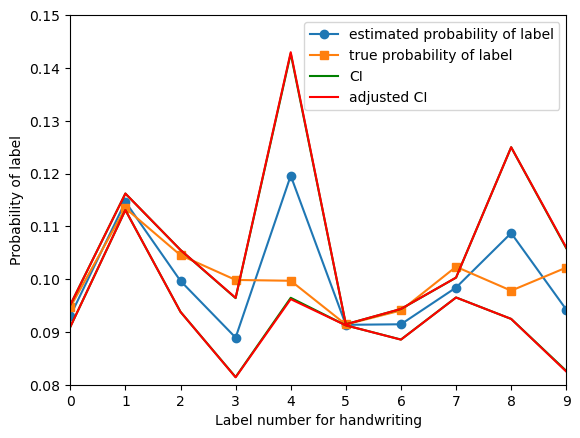

In [59]:
x_np = range(0, 10)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
adj_c_np = adj_c.detach().numpy()
adj_c_p_np = adj_c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated probability of label')
plt.plot(x_np, y_np, 's-', label='true probability of label')
plt.plot(x_np, c_np[0,:,0], '-', label='CI', color='green')
plt.plot(x_np, c_np[0,:,1], '-',color='green')
plt.plot(x_np, adj_c_np[0,:,0], '-', label='adjusted CI', color='red')
plt.plot(x_np, adj_c_np[0,:,1], '-',color='red')
plt.xlim(0, 9)
plt.ylim(0.08, 0.15)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Label number for handwriting')
plt.ylabel('Probability of label')
plt.legend()
plt.savefig('MNIST NN layer44444.jpg', format='jpg')
plt.show()


In [1]:
# import torch

# # Save the results to a file
# torch.save({'adj_c': adj_c, 'adj_c_p': adj_c_p, 'mu': mu, 'y_p': y_p,
#             'c': c, 'c_p': c_p, 'mu': mu, 'y_p': y_p}, 'confidence_intervals_MINIST_layers4.pth')

# # Load the data back into your program
# loaded_data = torch.load('confidence_intervals_MINIST_layers4.pth')

# # Access the saved variables
# loaded_adj_c = loaded_data['adj_c']
# loaded_adj_c_p = loaded_data['adj_c_p']
# loaded_mu = loaded_data['mu']
# loaded_y_p = loaded_data['y_p']
# loaded_c = loaded_data['c']
# loaded_c_p = loaded_data['c_p']
# loaded_mu = loaded_data['mu']
# loaded_y_p = loaded_data['y_p']


In [ ]:
# Print the result weights and biases of each layer
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'model.4.weight' in name:
        p=param
        
pp=p[5][-3:-1].detach().numpy()

In [ ]:
F, G, grad_vector = fisher_diagonal(model,5)
f = F[-3:-1,-3:-1]
f

In [ ]:
H=torch.inverse(f)
h = H/len( y)
h

In [ ]:
adj = Adj[5][-3:-1,-3:-1]
adj

In [ ]:
cov_matrix = h.numpy()
a = adj.numpy()
cov_matrix2 =cov_matrix + a

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def plot_confidence_ellipse(covariance_matrix, ax, n_std=2, **kwargs):
    """
    Plot a confidence ellipse for a 2D distribution based on its covariance matrix.

    Parameters:
    - covariance_matrix: Covariance matrix of the distribution.
    - ax: Matplotlib axes on which to plot the ellipse.
    - n_std: Number of standard deviations for the ellipse. Default is 2 (95% confidence).
    - **kwargs: Additional keyword arguments to pass to the ellipse patch.

    Returns:
    - ellipse: Ellipse artist.
    """
    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate the angle of rotation for the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # Create a 2D grid of points on the unit circle
    theta = np.linspace(0, 2 * np.pi, 100)
    unit_circle = np.array([np.cos(theta), np.sin(theta)])
    print(eigenvalues.reshape(-1, 1))
    # Scale and rotate the unit circle to create the ellipse
    ellipse = n_std * np.sqrt(eigenvalues.reshape(-1, 1)) * unit_circle
    transformation_matrix = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                                      [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
    ellipse = np.dot(transformation_matrix, ellipse)

    # Extract the mean of the distribution
    mean = pp 

    # Plot the ellipse
    ellipse = ax.plot(ellipse[0, :] + mean[0], ellipse[1, :] + mean[1], **kwargs)
    return ellipse


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confidence ellipse with 90% confidence (1.645 standard deviations)
plot_confidence_ellipse(cov_matrix, ax, n_std=1.645, color='blue', alpha=0.3)
# Plot the confidence ellipse with 90% confidence (1.645 standard deviations)
plot_confidence_ellipse(cov_matrix2, ax, n_std=1.645, color='red', alpha=0.3)
plt.scatter(pp[0], pp[1], color='red', label='parameter')
# Set axis labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('90% Confidence Ellipse')

plt.show()


In [ ]:

fig, ax = plt.subplots()

plot_confidence_ellipse(cov_matrix, ax, n_std=1.645, color='blue', alpha=0.3, label='unadjusted var')
plot_confidence_ellipse(cov_matrix2, ax, n_std=1.645, color='red', alpha=0.3, label='adjusted var')
plt.scatter(pp[0], pp[1], color='red', label='parameter')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('90% Confidence Ellipse')
plt.xlim(pp[0]-100, pp[0]+100)  
plt.ylim(pp[1]-100, pp[1]+100) 
# Show the plot
plt.legend()
plt.savefig('MNIST part.jpg', format='jpg')
plt.show()
